In [ ]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import operator
import math
import cv2
import numpy as np
import sklearn
import sklearn.model_selection
import imgaug
import tensorflow as tf
from tensorflow.keras.models import save_model
from faker import Faker
from collections import defaultdict
import operator
import sys
sys.path.append('../Packages/')
from modified_keras_ocr import keras_ocr

In [ ]:
data_dir = '.'
image_width = 500
image_height = 500
fonts = []
for file in os.listdir("../arabic fonts"):
  fonts.append("../arabic fonts/"+file)
RGB_Colors = [
               [255, 255, 0]    #Yellow
              ,[0, 0, 255]      #Blue
              ,[255, 0, 0]      #Red
              ,[0, 255, 0]      #Green
              #,[255, 192, 203]  #Pink
              ,[255, 165, 0]    #Orange
              #,[147, 112, 219]    #Purple
               ]
letters = 'أإآىدجحخهعغفقثصضشسيبلاتنمكطظزوةرؤءئذ'
digits = '٠١٢٣٤٥٦٧٨٩'
alphabet = '. ؟ ! ّ ء  ً ~ ُ َ ِ ْ َّ ُّ ّْ، - _ "'
for letter in letters:
  alphabet += letter + " "
for digit in digits:
  alphabet += digit + " "
fake = Faker('ar')
#backgrounds = []
#for file in os.listdir("backgrounds"):
#  backgrounds.append("./backgrounds/"+file)

Mounted at /content/drive


In [ ]:
def arabic_text_generator():
    yield fake.sentence()

In [ ]:
samples_num = 30
dataset = []
for i in range(samples_num):
  text = next(arabic_text_generator())
  font_index = random.choice(range(len(fonts)))
  image = keras_ocr.data_generation.draw_text_image(text, 60, image_width, image_height, {alphabet: fonts[font_index]}, lang = 'ar')
  dataset.append(image)

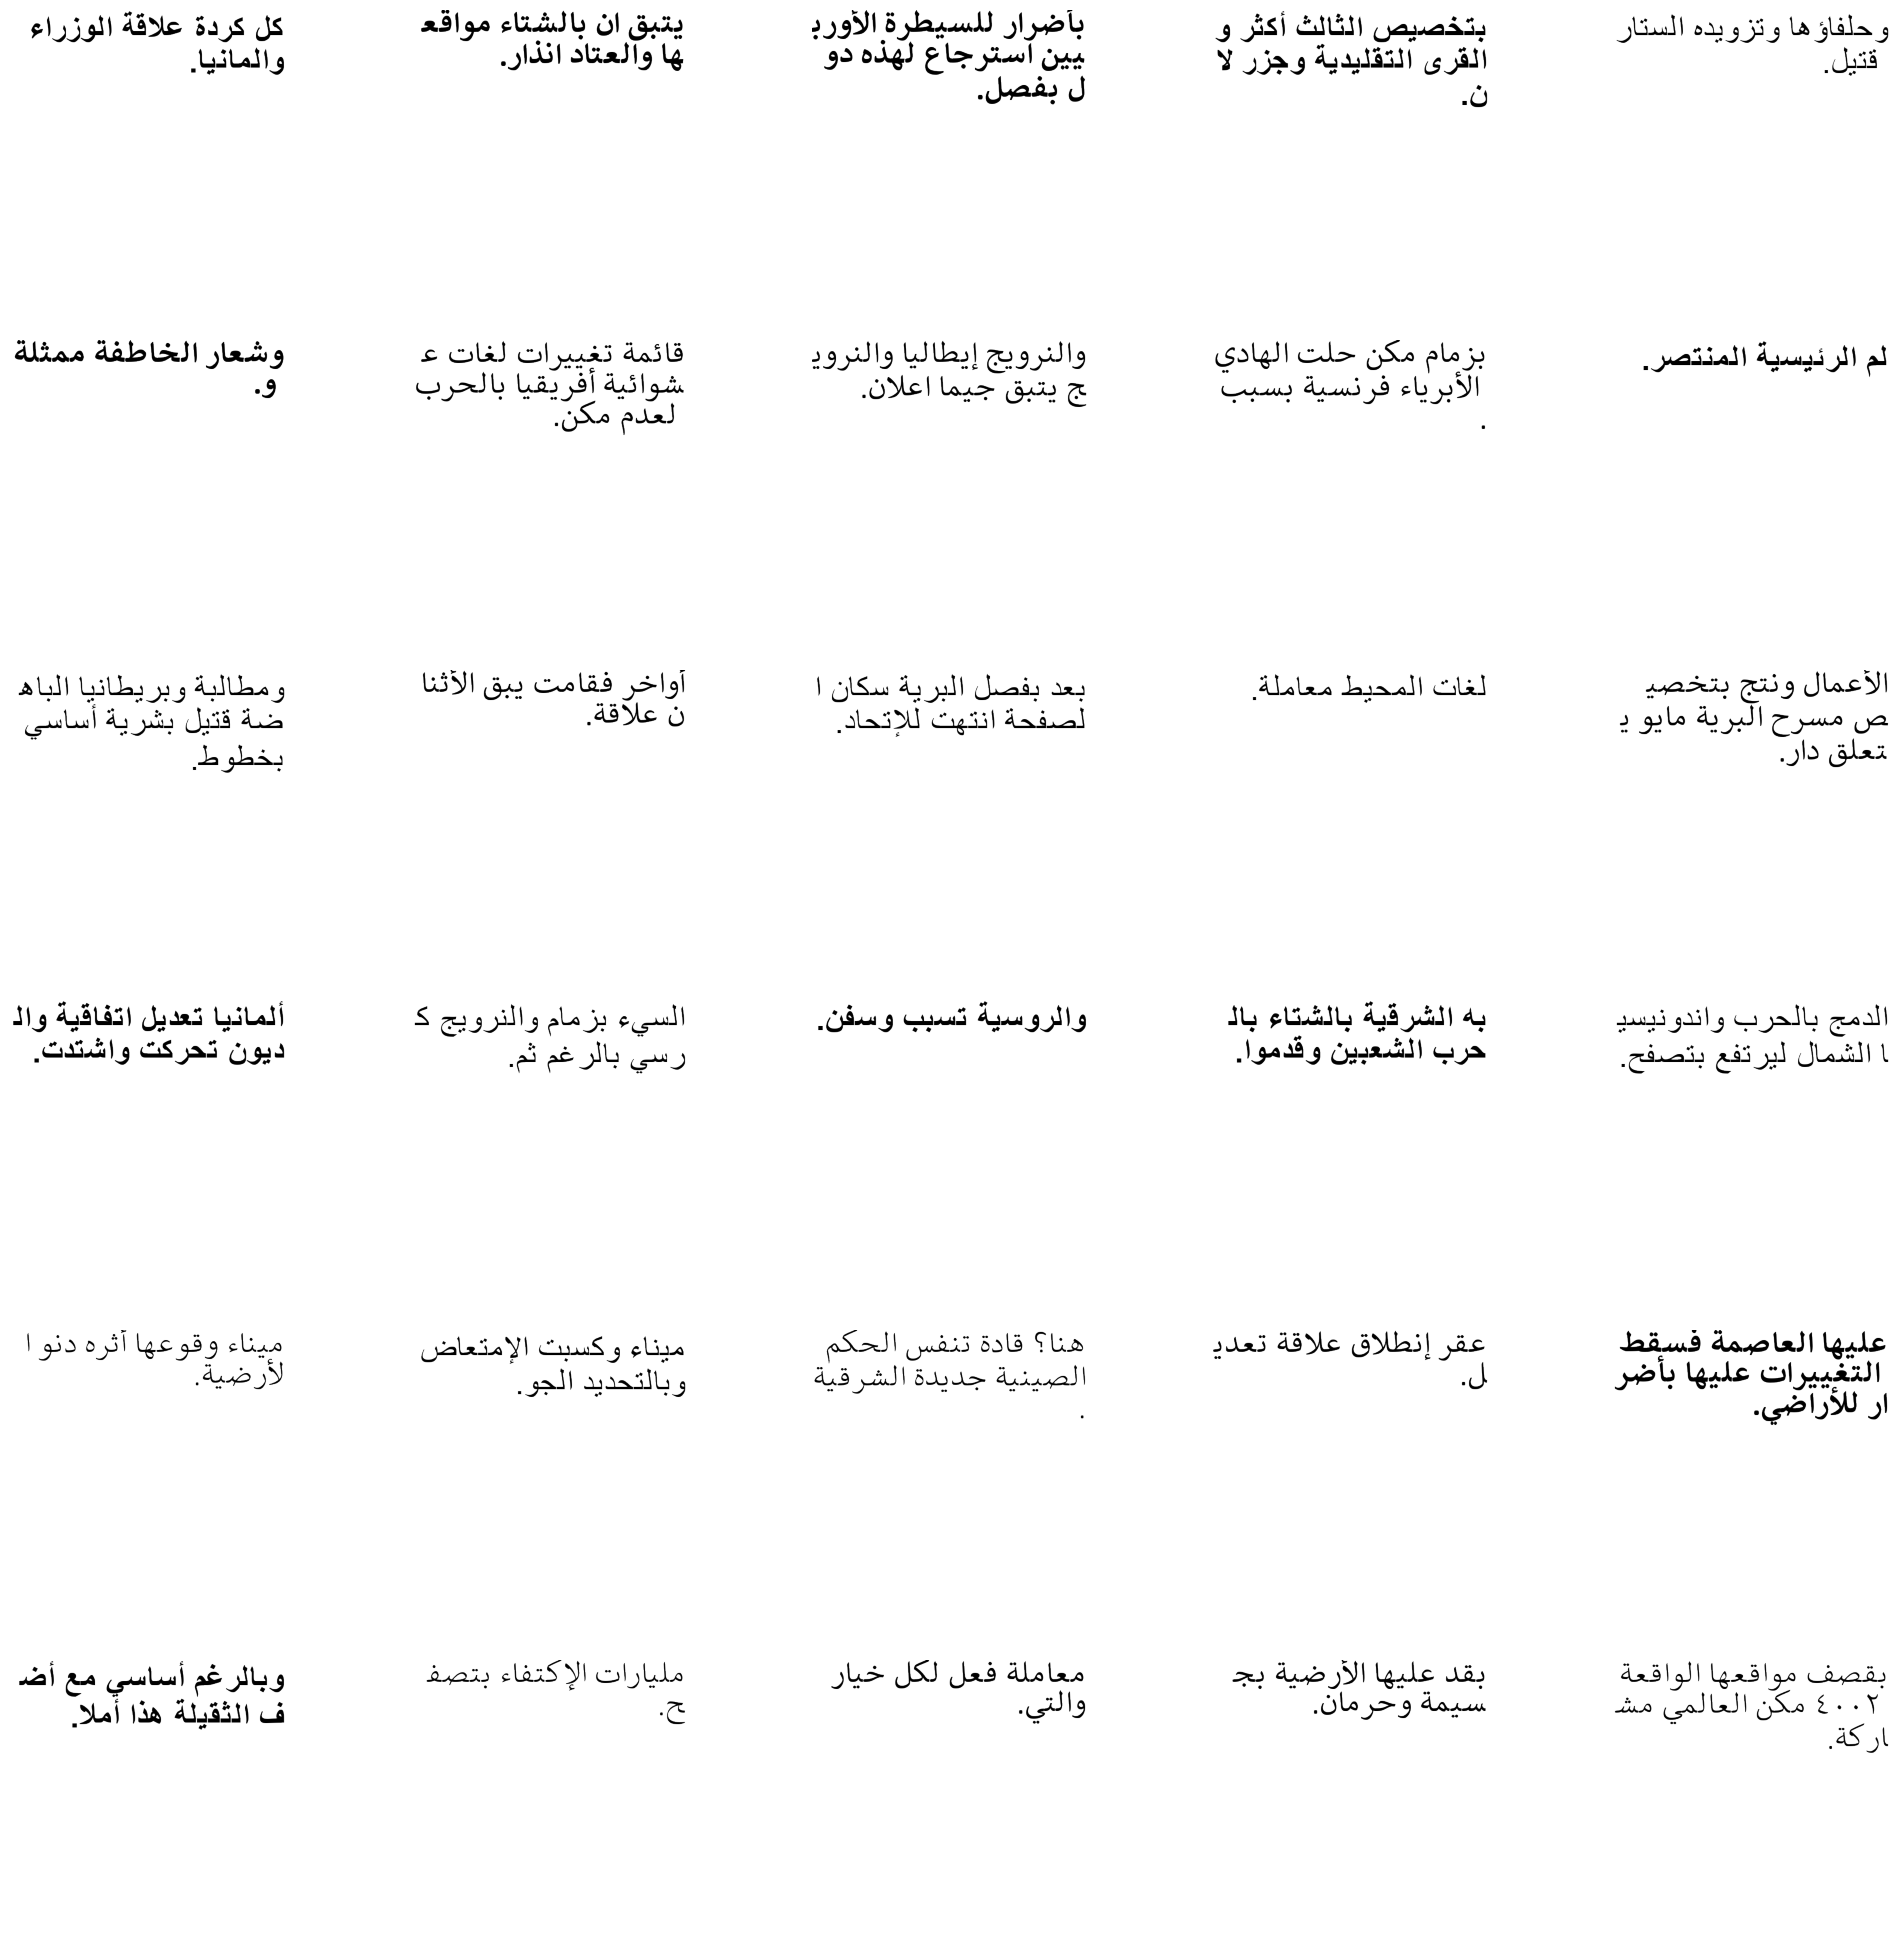

In [ ]:
fig = plt.figure(figsize=(25, 25))
rows = math.ceil(len(dataset)/5)
columns = 5

for i, image in enumerate(dataset):
  fig.add_subplot(rows, columns, i + 1)
  plt.imshow(image[0])
  plt.axis('off')

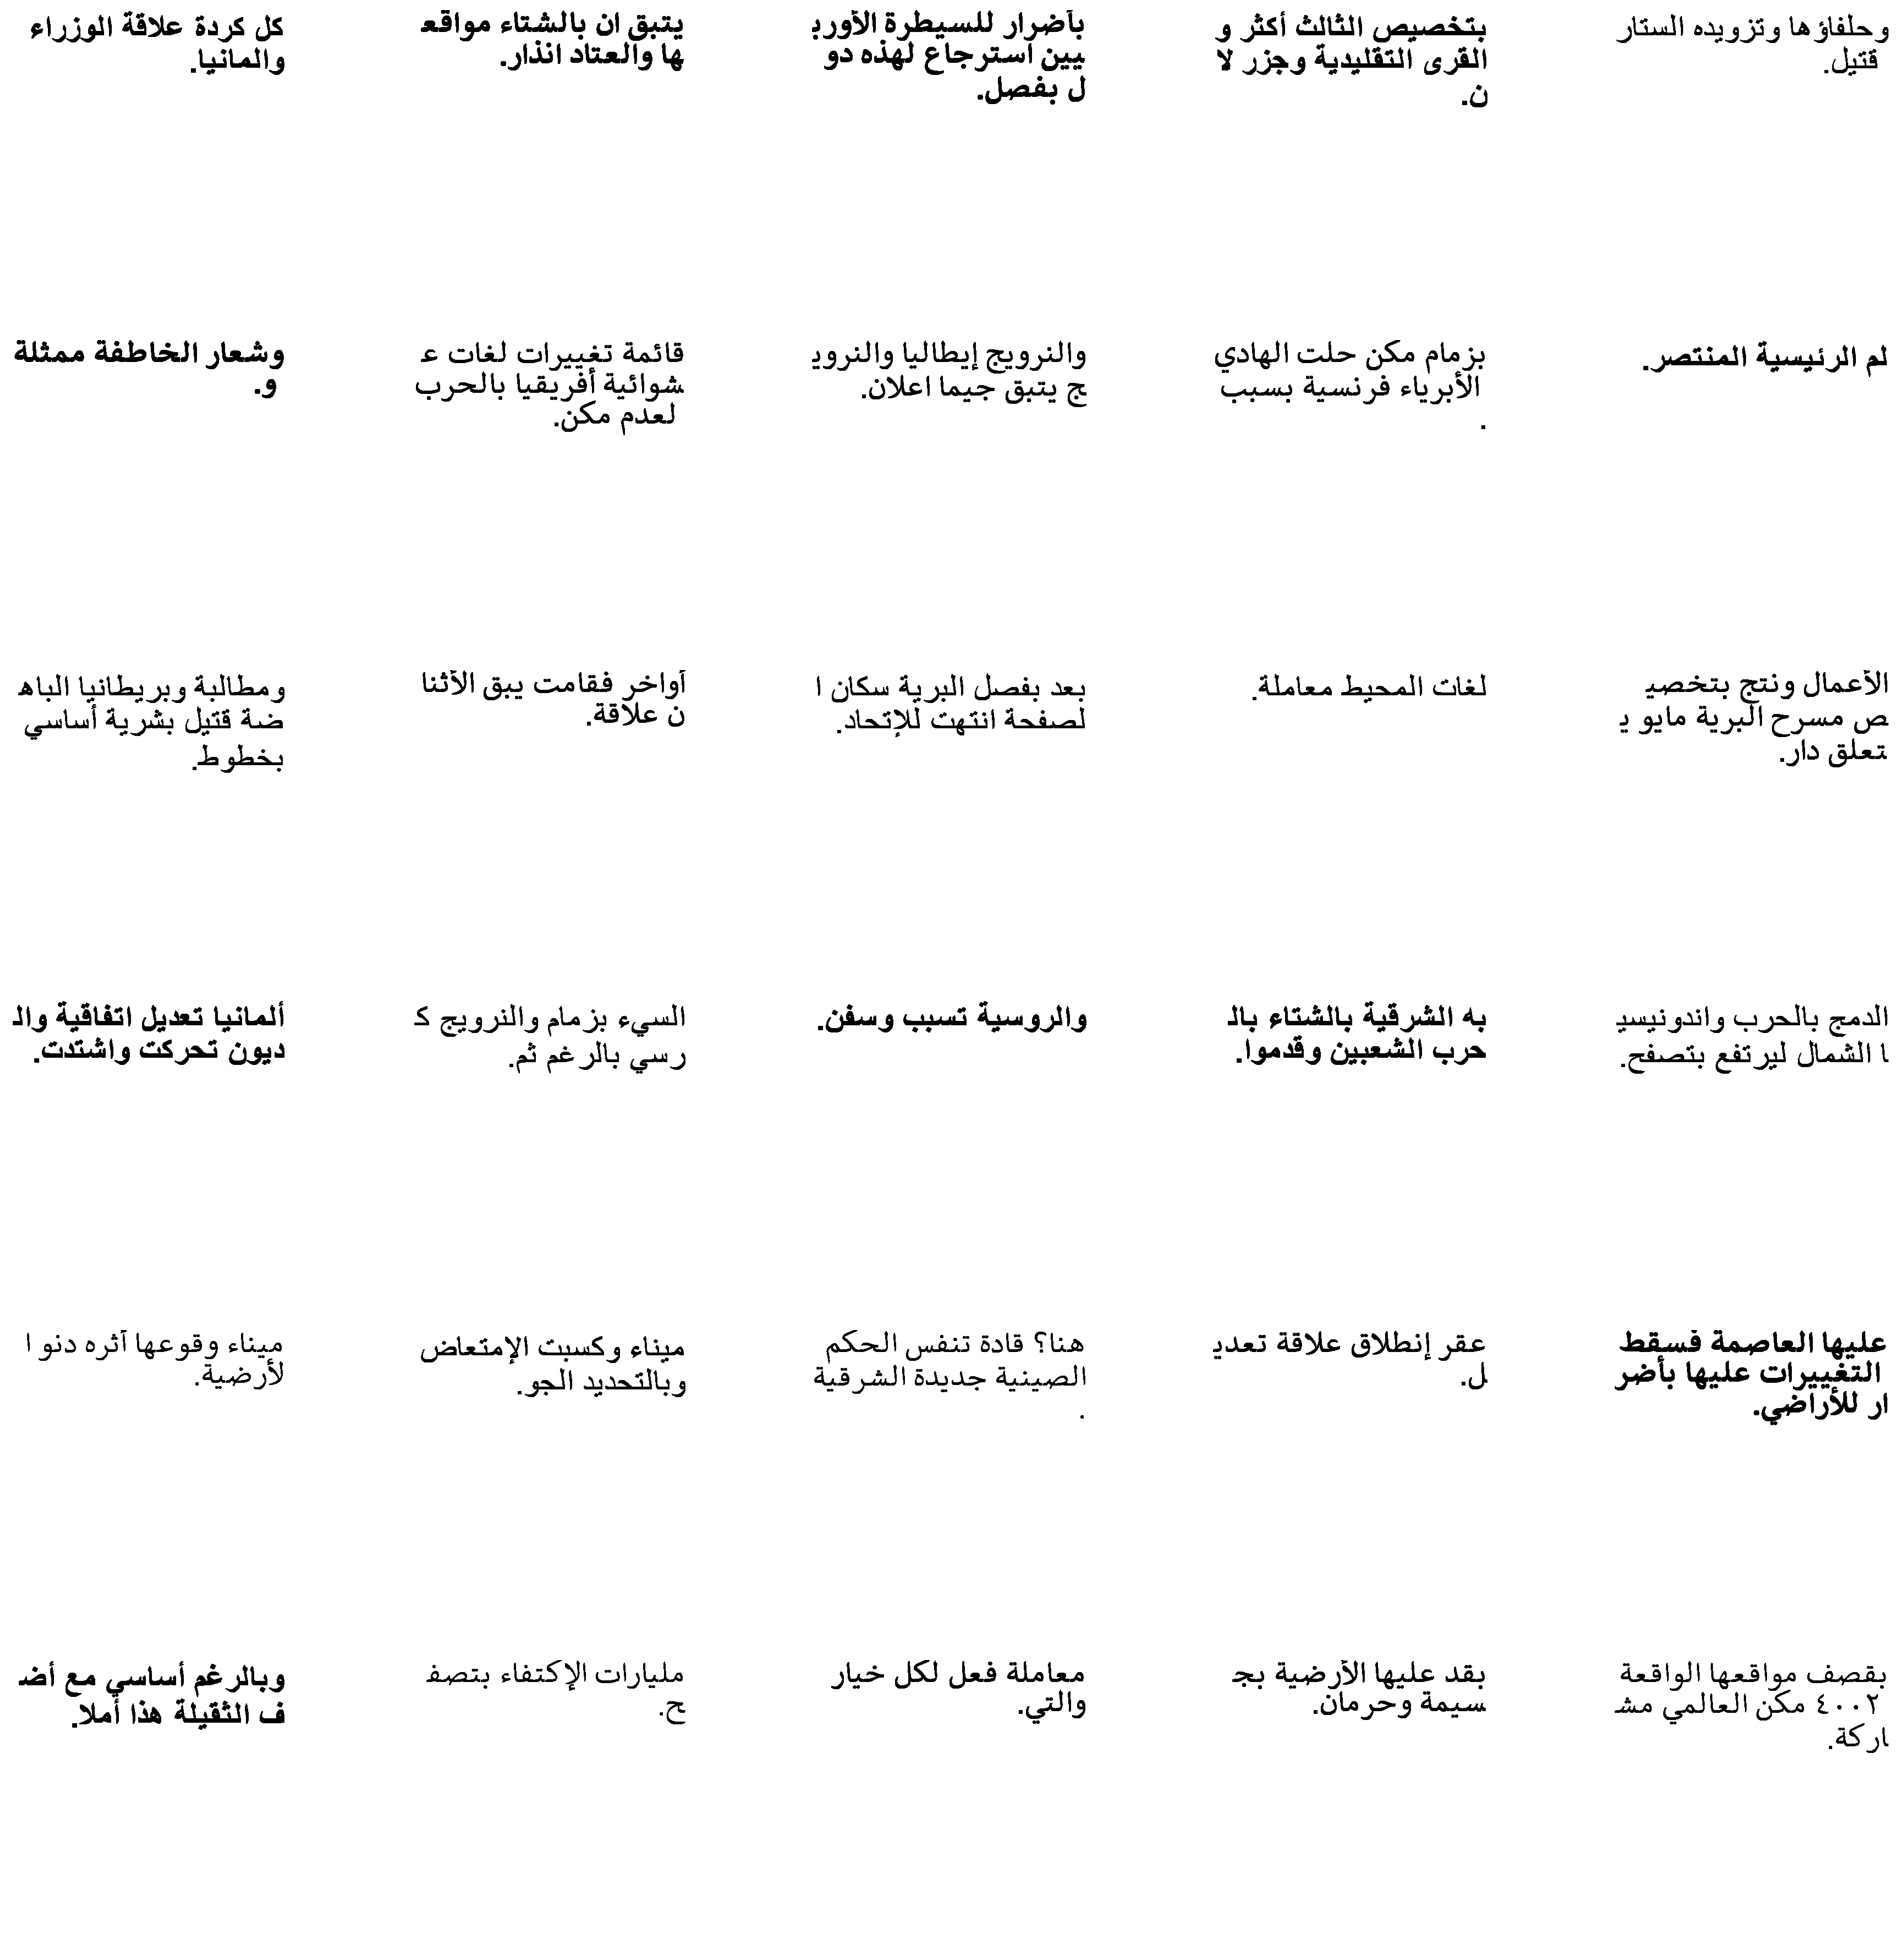

In [ ]:
for i, image in enumerate(dataset):
  dataset[i] = (cv2.cvtColor(image[0], cv2.COLOR_RGBA2RGB), image[1])
fig = plt.figure(figsize=(25, 25))
rows = math.ceil(len(dataset)/5)
columns = 5

for i, image in enumerate(dataset):
  fig.add_subplot(rows, columns, i + 1)
  plt.imshow(image[0])
  plt.axis('off')

In [ ]:
highlighted_word_annotated_dataset = []
for image in dataset:
  lines_number = len(image[1])
  random_lines_number = random.choice(range(1,lines_number+1))
  random_lines_indices = []
  for q in range(random_lines_number):
    rlnum = random.choice(range(lines_number))
    while(rlnum in random_lines_indices):
      rlnum = random.choice(range(lines_number))
    random_lines_indices.append(rlnum)
  lines_annotation = []
  for rln in range(lines_number):
    if rln not in random_lines_indices:
      #lines_annotation.append([])
      continue
    line_annotation = []
    spaces_positions = [i for i in range(len(image[1][rln])) if image[1][rln][i][1] == ' ']
    line_words_number = len(spaces_positions) + 1
    spaces_positions.insert(0, 0)
    spaces_positions.append(len(image[1][rln]))
    random_words_number = random.choice(range(1,line_words_number+1))
    random_word_indices = []
    for q in range(random_words_number):
      rwnum = random.choice(range(1, line_words_number + 1))
      while(rwnum in random_word_indices):
        rwnum = random.choice(range(1, line_words_number + 1))
      random_word_indices.append(rwnum)
    for rwn in range(1, line_words_number + 1):
      if rwn not in random_word_indices:
        continue
      word_position = np.zeros(dtype=np.float32, shape=(4,2))
      word_chars_indices = range(spaces_positions[rwn - 1] + 1, spaces_positions[rwn]) if spaces_positions[rwn - 1] != 0 else range(spaces_positions[rwn - 1], spaces_positions[rwn])
      word_letters_num = len(word_chars_indices)
      word_position[0][0] = word_position[3][0] = min(image[1][rln][word_chars_indices[word_letters_num-1]][0][0][0], image[1][rln][word_chars_indices[word_letters_num-1]][0][3][0])
      word_position[1][0] = word_position[2][0] = max(image[1][rln][word_chars_indices[0]][0][1][0], image[1][rln][word_chars_indices[0]][0][2][0])
      word_position[0][1] = word_position[1][1] = min([min(image[1][rln][k][0][0][1], image[1][rln][k][0][1][1]) for k in (word_chars_indices)])
      word_position[2][1] = word_position[3][1] = max([max(image[1][rln][k][0][2][1], image[1][rln][k][0][3][1]) for k in (word_chars_indices)])
      line_annotation.append((word_position, "".join([(image[1][rln][k][1]) for k in word_chars_indices])))
      w1 = int(min(word_position[0][0], min(word_position[1][0], min(word_position[2][0],word_position[3][0]))))
      w2 = int(max(word_position[0][0], max(word_position[1][0], max(word_position[2][0],word_position[3][0]))))
      h1 = int(min(word_position[0][1], min(word_position[1][1], min(word_position[2][1],word_position[3][1]))))
      h2 = int(max(word_position[0][1], max(word_position[1][1], max(word_position[2][1],word_position[3][1]))))
      color = RGB_Colors[random.choice(range(len(RGB_Colors)))]
      for i in range(image_width):
        for j in range(image_height):
          if (i in range(h1,h2) and j in range(w1,w2)):
            if(image[0][i][j][0] == 255 and image[0][i][j][1] == 255 and image[0][i][j][2] == 255):
              image[0][i][j] = color
    lines_annotation.append(line_annotation)
  highlighted_word_annotated_dataset.append((image[0], lines_annotation, 1))

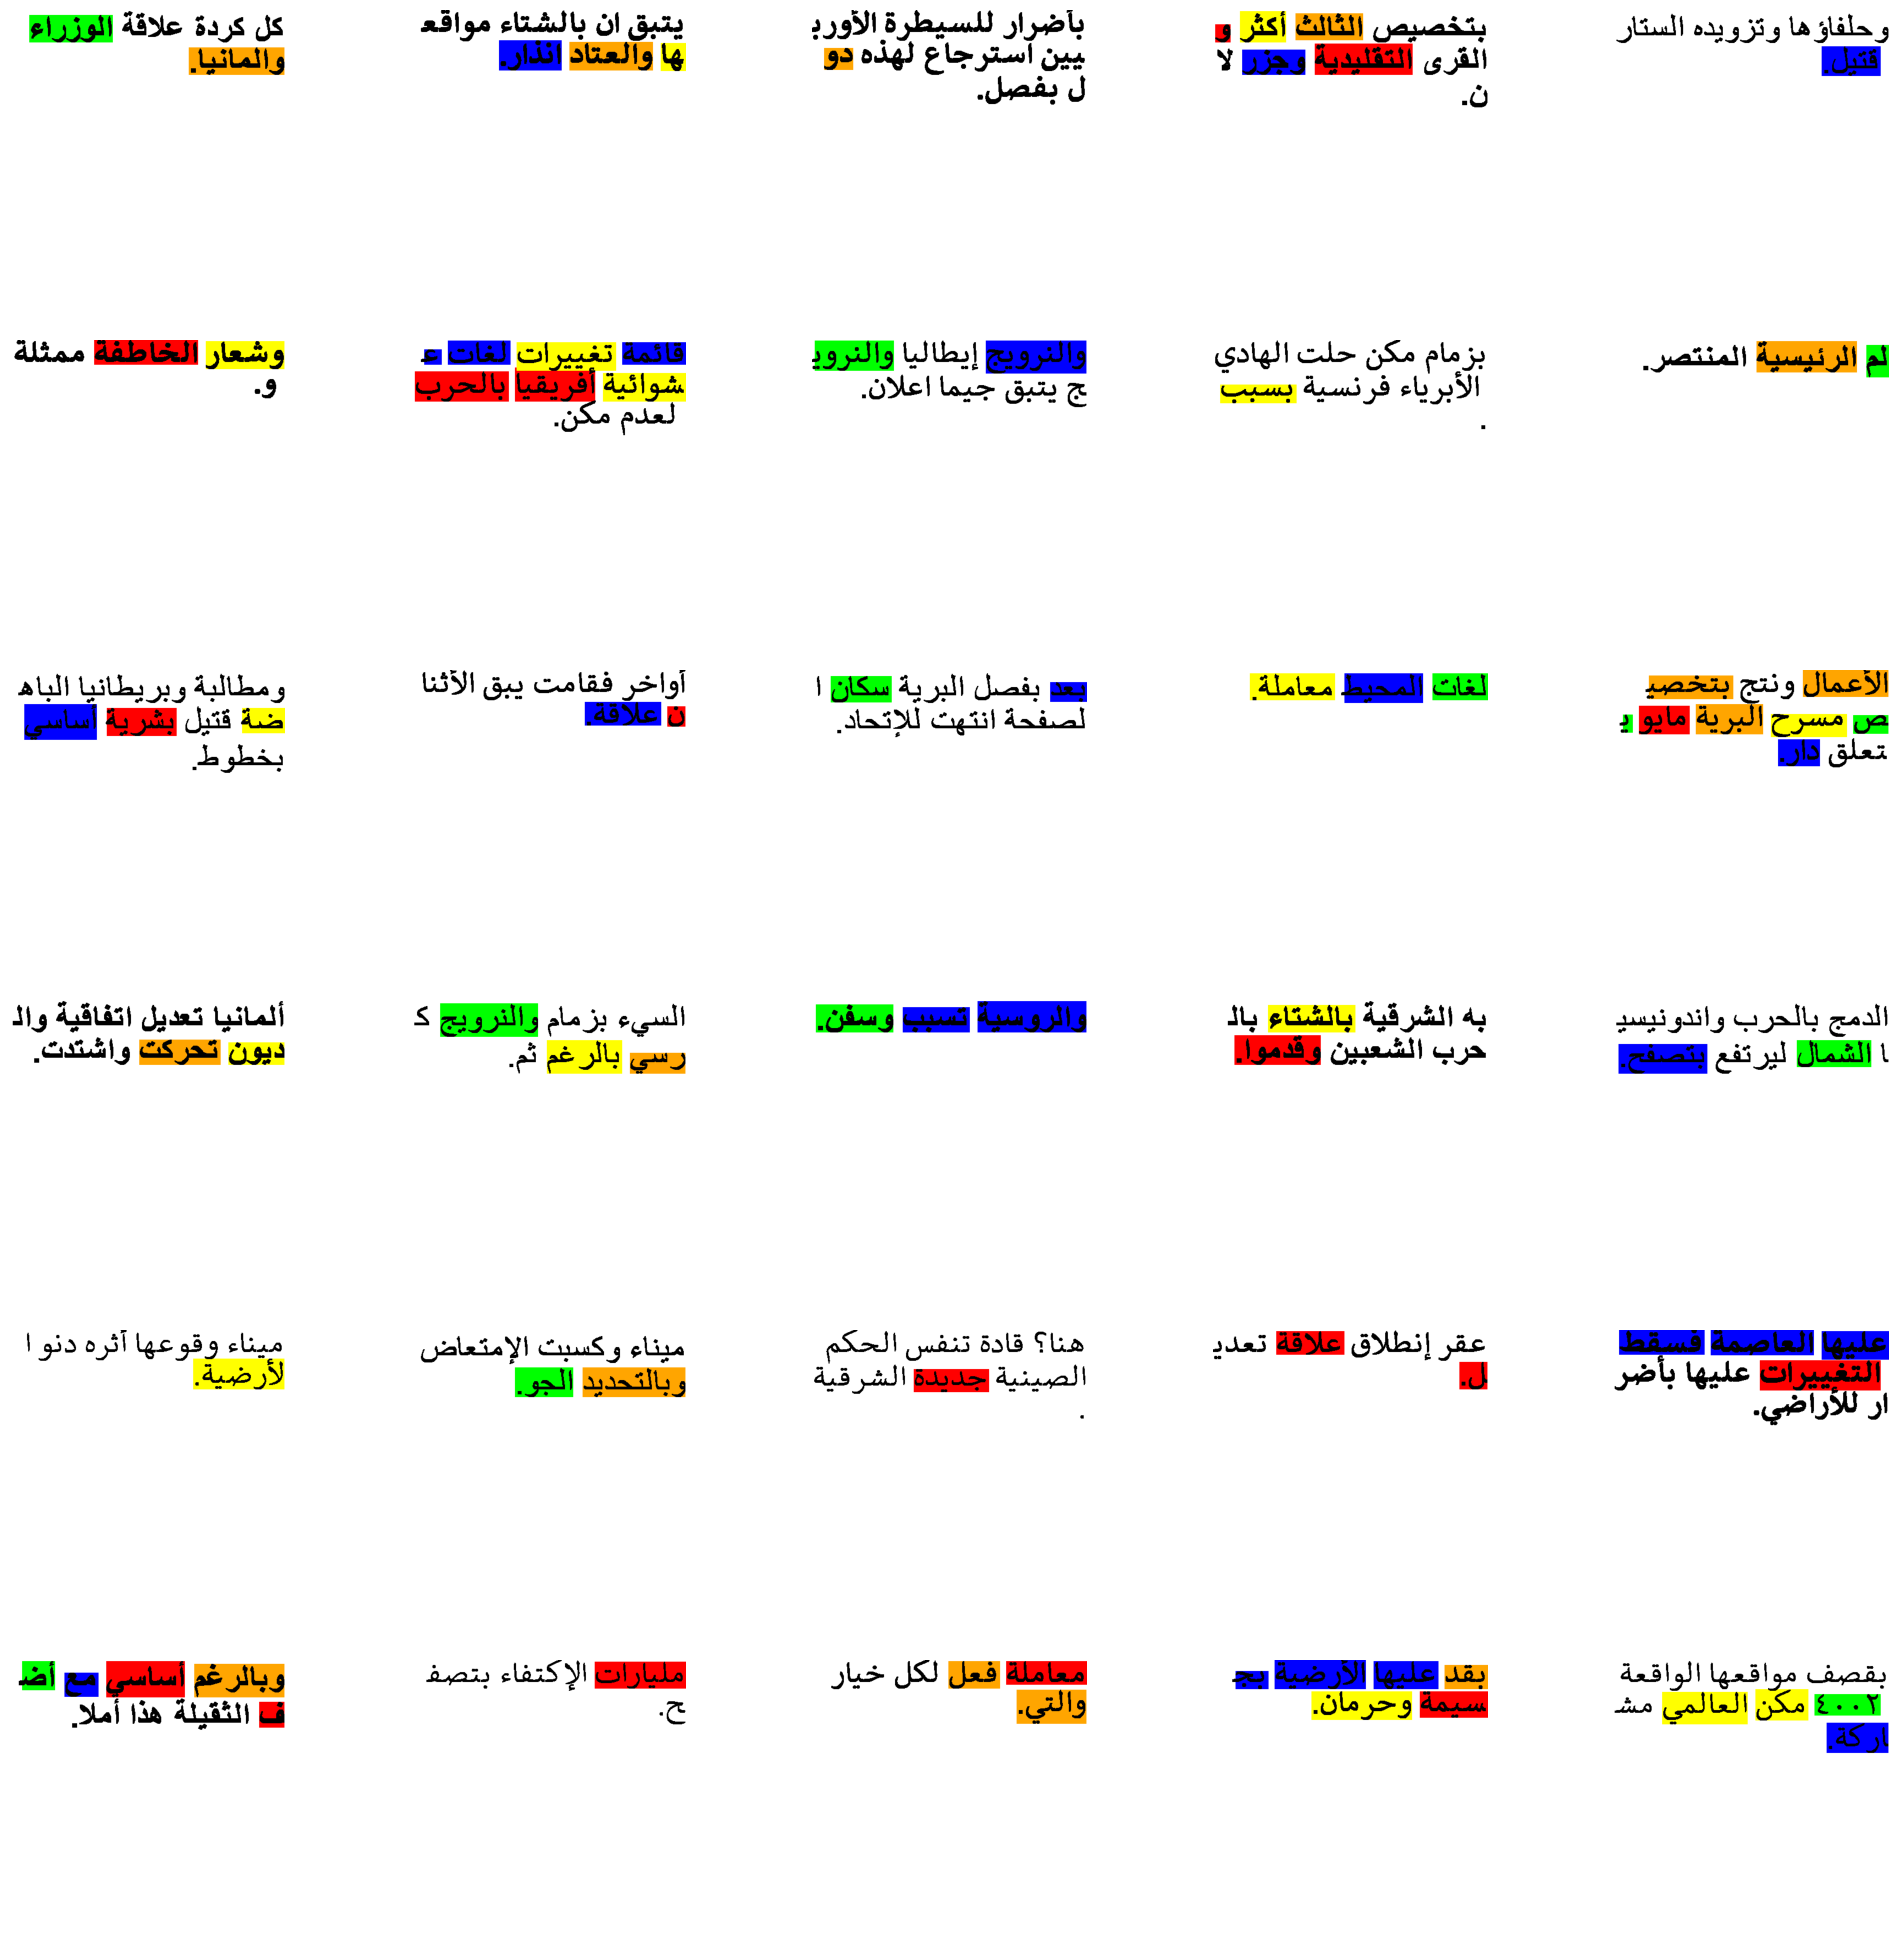

In [ ]:
fig = plt.figure(figsize=(25, 25))
rows = math.ceil(len(highlighted_word_annotated_dataset)/5)
columns = 5

for i, image in enumerate(highlighted_word_annotated_dataset):
  fig.add_subplot(rows, columns, i + 1)
  plt.imshow(image[0])
  plt.axis('off')

In [ ]:
train, validation = sklearn.model_selection.train_test_split(
    highlighted_word_annotated_dataset, train_size=0.8, random_state=42
)
random_augmenter = imgaug.augmenters.OneOf([
    imgaug.augmenters.Identity(),
    imgaug.augmenters.Affine(scale=(1.0, 1.2)),
    imgaug.augmenters.Affine(rotate=(-5, 5)),
    imgaug.augmenters.Affine(translate_px={"x":-40}),
    imgaug.augmenters.GaussianBlur(sigma=(0, 3)),
    imgaug.augmenters.MedianBlur(k=(3, 11)),
    imgaug.augmenters.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6)),
    imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2),
    ])
brightness_augmenter = imgaug.augmenters.WithBrightnessChannels(imgaug.augmenters.Add((-50, 100)))
augmenter = imgaug.augmenters.Sequential([
    random_augmenter,
    brightness_augmenter
])
generator_kwargs = {'width': image_width, 'height': image_height}
training_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=train,
    augmenter=augmenter,
    **generator_kwargs
)
validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=validation,
    **generator_kwargs
)

In [ ]:
elem = next(training_image_generator)

(-0.5, 499.5, 499.5, -0.5)

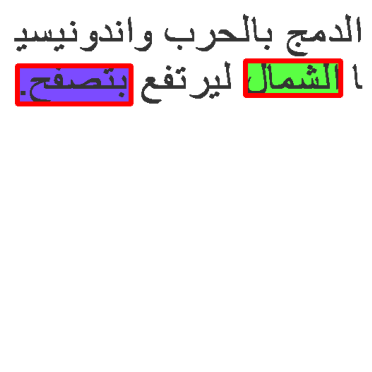

In [ ]:
fig = plt.figure(figsize=(10, 10))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
canvas1 = keras_ocr.tools.drawBoxes(image=elem[0], boxes=elem[1], boxes_format='lines')
plt.imshow(canvas1)
plt.axis('off')

In [ ]:
detector = keras_ocr.detection.Detector()

batch_size = 1
train_data_number = 10000
validation_data_number = 2500
training_generator, validation_generator = [
    detector.get_batch_generator(
        image_generator=image_generator, batch_size=batch_size
    ) for image_generator in
    [training_image_generator, validation_image_generator]
]
detector.model.fit_generator(
    generator=training_generator,
    steps_per_epoch=math.ceil(train_data_number / batch_size),
    epochs=1000,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(os.path.join(data_dir, 'detect_arabic_highlighted_text.csv')),
        tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(data_dir, '../Models/detect_arabic_highlighted_text.h5'))
    ],
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_data_number / batch_size)
)

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Epoch 1/1000


<ipython-input-21-e1f2af016836>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  detector.model.fit_generator(


10000/10000 [==============================] - 1633s 160ms/step - loss: 1.3508e-04 - val_loss: 0.0020
Epoch 2/1000
10000/10000 [==============================] - 1626s 163ms/step - loss: 1.0482e-04 - val_loss: 2.9674e-04
Epoch 3/1000
10000/10000 [==============================] - 1601s 160ms/step - loss: 7.1582e-05 - val_loss: 3.4510e-04
Epoch 4/1000
10000/10000 [==============================] - 1602s 160ms/step - loss: 6.3025e-05 - val_loss: 1.8540e-04
Epoch 5/1000
10000/10000 [==============================] - 1628s 163ms/step - loss: 6.0283e-05 - val_loss: 5.7248e-04
Epoch 6/1000
10000/10000 [==============================] - 1627s 163ms/step - loss: 5.1461e-05 - val_loss: 0.0014
Epoch 7/1000
 9637/10000 [===========================>..] - ETA: 53s - loss: 4.4715e-05

In [ ]:
save_model(detector.model, '../Models/final_detect_arabic_highlighted_text_31_Dec_2023.h5')

In [ ]:
detector = keras_ocr.detection.Detector()
detector.model.load_weights('../Models/detect_arabic_highlighted_text_31_Dec_2023.h5')

Looking for /root/.keras-ocr/craft_mlt_25k.h5


Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


1/1 [==============================] - 84s 84s/step


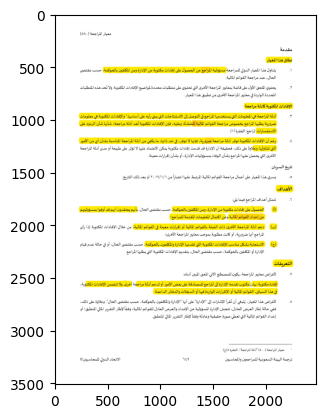

In [ ]:
image = plt.imread('../Data/test2.jpg')
#sorted(by_color.items(), key=operator.itemgetter(1), reverse = True)
image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
plt.imshow(image)
predictions = detector.detect(image.reshape(1,image.shape[0],image.shape[1],image.shape[2]))

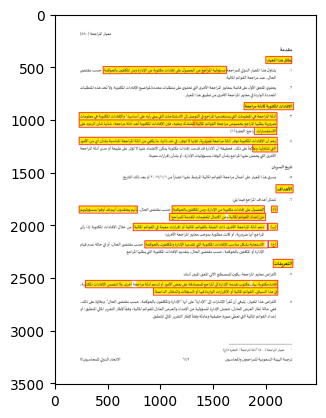

In [ ]:
drawn = keras_ocr.tools.drawBoxes(image, predictions[0], color=(255, 0, 0), thickness=5, boxes_format='boxes')
plt.imshow(drawn)

In [ ]:
for p, prediction in enumerate(predictions[0]):
  cropped_image = image[int(min(prediction[k][1] for k in range(4))):int(max(prediction[k][1] for k in range(4))),
                        int(min(prediction[k][0] for k in range(4))):int(max(prediction[k][0] for k in range(4))) ]
  plt.imsave("../Data/Pages/page 653/Cropped Line " + str(p + 1) + ".jpg", cropped_image)
  im = Image.open("../Data/Pages/page 653/Cropped Line " + str(p + 1) + ".jpg")
  by_color = defaultdict(int)
  for pixel in im.getdata():
    by_color[pixel] += 1
  highlighting_color = max(by_color.items(), key=operator.itemgetter(1))[0]
  for i in range(cropped_image.shape[0]):
    for j in range(cropped_image.shape[1]):
      if cropped_image[i][j][0] == 255 or cropped_image[i][j][1] == 255 or cropped_image[i][j][2] == 255:
        cropped_image[i][j][0] = highlighting_color[0]
        cropped_image[i][j][1] = highlighting_color[1]
        cropped_image[i][j][2] = highlighting_color[2]
  plt.imsave("../Data/Pages/page 653/PostProcessed-Cropped Line " + str(p + 1) + ".jpg", cropped_image)